In [1]:
import os
import csv
import ast
import time
import re
import numpy as np
import itertools
import random
from openpyxl import load_workbook
from scipy.spatial import distance
import spacy
from nltk.stem import LancasterStemmer, WordNetLemmatizer, SnowballStemmer, PorterStemmer
from greek_stemmer import GreekStemmer
from sklearn.model_selection import train_test_split
import textacy.extract.basics
from nltk.corpus import stopwords
from nltk import word_tokenize
from modern_greek_accentuation.accentuation import *
import pandas as pd
import gensim
from gensim.models.wrappers.ldamallet import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from scipy.signal import find_peaks
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import math
import json
from sklearn.metrics._classification import precision_recall_fscore_support
import nltk
nltk.download('punkt')
nltk.download('stopwords')


''' Constants and Global Variables'''

#LDA Training model constants

#documents to exclude from dictionary
#words to exclude if they appear in less than number of documents
not_less_than = 1
#words to exclude if they appear in more than percent of documents
not_more_than = 0.75

#LDA Optimal model iterations
OPTIMIMUM_NUMBER_OF_TOPICS_ENABLED = True
limit = 70
start = 25
step = 2

'''the prominence is used for finding the optimum coherence,
Lower prominence is for more sensitive fluctuations of coherence values'''
#peaks_prominence = 0.01
peaks_prominence = 0.005
# peaks_prominence = 0.008

''' Attention this is neccessary to be installed and set for the LDA algorith to function.
Check the manual for instructions'''
os.environ['MALLET_HOME'] = '/usr/local/mallet'
mallet_path = "/usr/local/mallet/bin/mallet"


#prepocessing constants
nlp = None
LANGUAGE = 'english'
STEMMING_ENABLED = True
MIN_WORDS_PER_DOC = 2
SPACE = " "



'''Themes distribution variables and constants'''
ALL_CATEGORIES = True 

'''Mapping between the standard documents and the springer category names.'''
CATEGORIES_MAPPING = {
    'Computer science': 'COMPUTER SCIENCE',
    'Engineering': 'TECH SCIENCES AND ENGINEERING',
    'Mathematics': 'MATHEMATICS',
    'Medicine' : 'HEALTH SCIENCES',
    'Physics':'PHYSICAL SCIENCES'
    }


def name_by_categories_no(name, all_categories_enabled):
    return name if all_categories_enabled else f'{name}_5_categories'


springer_dictionary_path = os.path.join(os.path.abspath(''), f'{name_by_categories_no("springer.dictionary",ALL_CATEGORIES)}')
springer_model_path = os.path.join(os.path.abspath(''), f'{name_by_categories_no("springer_lda.model",ALL_CATEGORIES)}')


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1131)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1131)>


In [2]:
''' Utility functions '''

''' Flattens a list of lists to a single list'''
def flatten(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

'''Normalizes the rows of dataframe'''
def normalize_df(df):
    df = df.apply(pd.to_numeric, errors='coerce', axis=1)
    return df.div(df.sum(axis=1), axis=0)

def normalize_rounded_df(df):
    return normalize_df(df).round(3)

def normalize_columns_df(df):
    df = df.apply(pd.to_numeric, errors='coerce', axis=1)
    return df.div(df.sum(axis=0), axis=1)


def normalize_columns_rounded_df(df):
    return normalize_columns_df(df).round(3)

def accumulated_frequency_of(items_to_check, items):
    accumulated_frequency = 0
    common_items = set(items_to_check).intersection(items)
    for item_to_check in common_items:
        accumulated_frequency += frequency_of(item_to_check, items)
    return accumulated_frequency

def frequency_of(item_to_check, items):
    return items.count(item_to_check)

def string_to_list(list_str):
    return ast.literal_eval(list_str)

def save_to_file(filename, data):
    if(type(data) is dict):
        w = csv.writer(open(filename + '.csv', "w"), delimiter=';')
        # loop over dictionary keys and values
        for key, val in data.items():
            # write every key and value to file
            w.writerow([key, val])
    else:
        df = pd.DataFrame(data)
        # df.to_pickle(filename + '.pkl')
        
        df.to_csv(filename + '.csv', sep=';')

def load_csv_to_dict(filename):
    with open(f'{filename}.csv', mode='r') as infile:
        reader = csv.reader(infile, delimiter=';')
        loaded_dict = {rows[0]:string_to_list(rows[1]) for rows in reader}
        return loaded_dict

def isNaN(string):
    return string != string

def replace_file_char_with_char(path, replace_from, replace_to):
    # read input file
    fin = open(path, "rt")
    # read file contents to string
    data = fin.read()
    # replace all occurrences of the required string
    data = data.replace(replace_from, replace_to)
    # close the input file
    fin.close()
    # open the input file in write mode
    fin = open(path, "wt")
    # overrite the input file with the resulting data
    fin.write(data)
    # close the file
    fin.close()

In [3]:
''' Preprocessing functions '''
def preprocess(docs, language, with_stemming):
    tic = time.perf_counter()
    print(f"Preprocessing of {1 if isinstance(docs, str) else len(docs) } {language} documents starting...")
    processed_docs = normalize_docs(docs=docs, lang=language, with_stemming=with_stemming, minimum_words_per_doc=MIN_WORDS_PER_DOC)
    toc = time.perf_counter()
    print(f"Normalisation of of {1 if isinstance(docs, str) else len(docs) } {language} documents completed in {toc - tic:0.4f} seconds")
    return processed_docs



def normalize_docs(docs, lang, with_stemming, minimum_words_per_doc):
    if not docs:
        return []
    docs = [docs] if isinstance(docs, str) else docs
    s = " "
    normalised_docs = []
    global nlp
    if (nlp == None):
        nlp = spacy.load("el_core_news_md" if lang == 'greek' else "en_core_web_md")
    to_be_processed_docs = remove_chars(docs)
    if(lang == 'greek'):
        to_be_processed_docs = keep_only_table_of_contents(to_be_processed_docs)
        to_be_processed_docs = remove_punctuation_doc(to_be_processed_docs)
    to_be_processed_docs, list_of_indexes_to_keep = replace_numbers_doc(to_be_processed_docs)
    print("Removing Stopwords, Stemming: {} Lemma:{}, Removing short and common words...".format(with_stemming, not with_stemming))
    for index, doc in enumerate(to_be_processed_docs):
        normalised_doc = None
        doc = remove_unnecessary_spaces(doc)
        bigrams_of_doc = nlp_bigrams(doc, nlp)
        words = list(map(lambda word: word.lower().strip(), word_tokenize(doc)))
        words.extend(bigrams_of_doc)
        no_stop_words = remove_stopwords(words, lang)
        if(with_stemming):
            normalised_doc = stem(no_stop_words, index, lang, True)
        else:
            m_doc = nlp(s.join(no_stop_words))
            normalised_doc = [token.lemma_ for token in m_doc]
        normalised_doc = remove_short_words(normalised_doc, 5)
        normalised_doc = remove_common_words(normalised_doc, lang)
        normalised_docs.append(normalised_doc)
    normalised_docs = list(filter(lambda doc: len(doc) >= minimum_words_per_doc, normalised_docs))
    
    return normalised_docs[0] if len(normalised_docs) == 1 else normalised_docs


''' to be used only for the greek dataset '''
def keep_only_table_of_contents(docs):
    print("keep_only_table_of_contents...cut everything that is before the first time that periexomena if found")
    """cut everything that is before the first time that periexomena if found"""
    new_docs = []
    for i, doc in enumerate(docs):
        index = 0
# #working only if periex is found once in the toc: index=re.search("περιεχ", doc, re.IGNORECASE).start()
        instances_array = [m.start() for m in re.finditer('περιεχ', doc, re.IGNORECASE)]
        # print(i)
        # print(instances_array)
        if len(instances_array) == 1:
            index = instances_array[0]
        elif len(instances_array) == 2:
            if instances_array[0] == 0:
                index = instances_array[0]
            else:
                index = instances_array[1]
        elif len(instances_array) == 0:
            index = 0
        else:
            index = instances_array[0]
        new_doc = doc[index:]
        new_docs.append(new_doc)
    return new_docs


def remove_punctuation_doc(docs):
    print("Remove punctuation from list of docs")
    """Remove punctuation from list of docs"""
    new_docs = []
    for index, doc in enumerate(docs):
        new_doc = re.sub(r'[^\w\s]', ' ', doc)
        new_docs.append(new_doc)
        # print(index)
    return new_docs


def trim(words):
    new_words = []
    for word in words:
        new_words.append(word.strip())
    return new_words


def replace_numbers_doc(docs):
    print("Replace all interger occurrences in list of docs")
    """Replace all interger occurrences in list of docs"""
    """In order to know which docs are not empty after removing all number occurrences"""
    list_of_indexes_to_keep = []
    new_docs = []
    regex = re.compile(r'\b(?=[MDCLXVI]+\b)M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})\b')
    for index, doc in enumerate(docs):
        result = ''.join(i for i in doc if not i.isdigit())
        result_no_romans = regex.sub(' ', result.upper())
        if not result_no_romans == '':
            list_of_indexes_to_keep.append(index)  # print(result)
            new_docs.append(result_no_romans.lower())
            
    return new_docs, list_of_indexes_to_keep


def remove_unnecessary_spaces(document):
    return re.sub(' +', ' ', document)


def nlp_bigrams(document, nlp):
    if nlp is None:
        nlp = spacy.load("el_core_news_md")
    nlp_doc = nlp(document)
    return list(set(textacy.extract.utils.terms_to_strings(list(textacy.extract.basics.ngrams(nlp_doc, 2, min_freq=2)), by="orth"))) 


def stop_words(lang):
    stopwords_enhanced = stopwords.words(lang)
    if lang == 'greek':
        list_with_words_to_be_removed = ['της', 'ως', 'από', 'στα', 'τους', 'μια', 'ένας', 'ένα', 'μία', 'στον', 'στο', 'στη', 'στους', 'στις', 'στα']
        stopwords_enhanced.extend(list_with_words_to_be_removed)
    return stopwords_enhanced


def remove_chars(docs):
    print("remove chars not to be used and tokenize")
    """remove chars not to be used and tokenize"""
    new_docs = []
    for doc in docs:
        s = re.sub('\n', ' ', str(doc))  # for greek_aei dataset
        s1 = re.sub('\t', ' ', s)
        s2 = re.sub('\ufeff', ' ', s1)
        s3 = re.sub('_', ' ', s2)
        s4 = re.sub('β€', ' ', s3)  # for springer dataset
        new_docs.append(s4)
    return new_docs


def remove_stopwords(words, lang):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        stopwords_enhanced = stop_words(lang) + stop_words('english')
        if word not in stopwords_enhanced:
            new_words.append(word)
    return new_words


def stem(document, index, lang, log_to_file):
    if lang == 'greek':
        normalised_doc = replace_accentuation(document)
    else:
        normalised_doc = document
    normalised_doc = stem_words(normalised_doc, lang, 'Snowball')
    return normalised_doc


def stem_words(words, lang, stemmer=None):
    """Stem words in list of tokenized words"""
    if lang == 'english':
        if stemmer == 'Lancaster':
            stemmer = LancasterStemmer()
        elif stemmer == 'Porter':
            stemmer = PorterStemmer()
        elif stemmer == 'Snowball':
            stemmer = SnowballStemmer('english')
    else:
        stemmer = GreekStemmer()
    stems = []
    for word in words:
#         if (len(word.split())>1):
#             print("bigram found-> {}.".format(word))
        trimmed = trim(word.split())
        stemmed_sentece = [];
        for trimmed_word in trimmed:
            stemmed_sentece.append(stemmer.stem(trimmed_word.upper()))
        stems.append("_".join(stemmed_sentece).lower())    
    return stems


def replace_accentuation(words):
    """replace tonous"""
    new_words = []
    for word in words:
#         new_word = strip_accents(word)
        new_word = remove_all_diacritics_with_diaer(word)
        new_words.append(new_word)
    return new_words


def remove_short_words(words, min_length):
    """Removes words less than the minimum threshold set"""
    filtered_tokens = list(filter(lambda word: len(word) >= min_length, words));
    return filtered_tokens


def remove_common_words(words, lang):
    if lang == 'greek':
        list_with_common_words = ['ΠΕΡΙΕΧΟΜΕΝ', 'ΠΕΡΙΕΧ', 'ΑΣΚΗΣ', 'ΕΥΡΕΤΗΡ', 'ΕΙΣΑΓΩΓ', 'ΚΕΦΑΛΑΙ', 'ΒΙΒΛΙΟΓΡΑΦ', 'ΕΙΝΑΙ', 'ΠΡΟΛΟΓ', 'ΚΑΤΑΛΟΓ', 'ΕΚΔΟΤ', 'ΕΚΔΟΣ', 'ΜΕΤΑΦΡΑΣΤ',
                                  'περιεχομεν', 'περιεχ', 'ασκησ', 'ευρετηρ', 'εισαγωγ', 'κεφαλαι', 'βιβλιογραφ', 'ειναι', 'ειν', 'προλογ', 'καταλογ', 'εκδοτ', 'εκδοσ', 'μεταφραστ', 'περιληψ',
                                  'περιεχόμενο', 'άσκηση', 'ευρετήριο', 'εισαγωγη', 'κεφάλαιο', 'πρόλογος', 'κατάλογος', 'εκδότης', 'μεταφραστ΄ής',
                                  'περιέχει', 'βιβλιογραφία', 'είναι', 'έκδοση', 'περίληψη', 'τελος', 'τροπο',
                                  'περιεχομενο', 'ασκηση', 'ευρετηριο', 'εισαγωγη', 'κεφαλαιο', 'προλογος', 'καταλογος', 'εκδοτης', 'μεταφραστης',
                                  'περιεχόμενα', 'ασκήσεις', 'ευρετήρια', 'εισαγωγές', 'κεφάλαια', 'πρόλογοι', 'κατάλογοι', 'εκδότες', 'μεταφραστές',
                                  'περιεχομενα', 'ασκησεις', 'ευρετηρια', 'εισαγωγες', 'κεφαλαια', 'προλογοι', 'καταλογοι', 'εκδοτες', 'μεταφραστες',
                                  'περιεχει', 'βιβλιογραφια', 'ειναι', 'εκδοση' , 'βιβλιο', 'βιβλιου', 'περιληψη', 'συνοψη',
                                  'ελλην', 'εκδος', 'σημειωμ', 'συγγραφ', 'προσωπ', 'γιατι', 'ακομη', 'σχετικα', 'γενικα',
                                  'μεταξυ', 'πρεπει', 'εχουν', 'υπαρχω', 'υπαρχεις', 'υπαρχει', 'υπαρχουν', 'κανεις',
                                  'μπορω', 'μπορεις', 'μπορει', 'μπορουμε', 'μπορουν', 'γινεται', 'δηλαδη', 'εχουμε'
                                  'αποτελω', 'αποτελεις', 'αποτελει', 'αποτελουν', 'πλεον', 'συχνα',
                                  'αυτος', 'αυτη', 'αυτης', 'αυτο', 'αυτων', 'αυτου', 'αυτοι', 'αυτες', 'πολλα', 'πολλες΄',
                                  'οποιος', 'οποια', 'οποιο', 'οποιοι', 'οποιες', 'ποιος', 'ποια', 'ποιο', 'ποιοι', 'ποιες', 'επισης', 'καθως', 'σημερα']
    else:
        list_with_common_words = ['introduction', 'conclusions', 'preface', 'index', 'references', 'foreward', 'acknowledgments', 'chapter', 'appendix', 'part', 'introduct', 'conclus', 'refer', 'discuss', 'result', 'suggest', 'appendic', ]
    filtered_tokens = []
    for w in words:
        if (w not in list_with_common_words):
            filtered_tokens.append(w)
    return filtered_tokens

In [4]:
''' function for the subjects (retrieval and processing)'''
def get_preprocessed_subjects(subjects_file_name):
    all_categories_df = get_subjects(file_name=subjects_file_name)
    if (ALL_CATEGORIES):
        categories_df = all_categories_df
    else:
        categories_df = all_categories_df[all_categories_df['category'].isin(['COMPUTER SCIENCE', 'TECH SCIENCES AND ENGINEERING', 'MATHEMATICS', 'HEALTH SCIENCES', 'CHEMISTRY', 'PHYSICS', 'ASTRONOMY AND ASTROPHYSICS'])]    
        physical_sciences = categories_df[categories_df['category'].isin(['CHEMISTRY', 'PHYSICS', 'ASTRONOMY AND ASTROPHYSICS'])].content.values.tolist()
        physical_sciences_content = ""
        for idx in range(len(physical_sciences)): 
            physical_sciences_content += physical_sciences[idx][1:-1]
        categories_df = categories_df.drop(categories_df[categories_df['category'].isin(['CHEMISTRY', 'PHYSICS', 'ASTRONOMY AND ASTROPHYSICS'])].index)
        categories_df = categories_df.append({'category':'PHYSICAL SCIENCES', 'content':'[' + physical_sciences_content + ']'}, ignore_index=True)
    preprocessed_categories_df = preprocess_subjects(categories_df)
    return preprocessed_categories_df
 

''' Load Themes (Standard Documents) functions'''
def init_subjects(docs_name, file_to_save, language):
    wb = load_workbook(docs_name)
    categories_dictionary = {}
    for n, worksheet in enumerate(wb.worksheets):
        dict_key = worksheet.title
        cell_values = []
        for col_cells in worksheet.iter_cols(min_col=1, max_col=1):
            for cell in col_cells:
                cell_values.append(cell.value)
        normalized_categories = normalize_docs([SPACE.join(cell_values)], lang=language, with_stemming=STEMMING_ENABLED, minimum_words_per_doc=4)
        categories_dictionary[dict_key] =  normalized_categories[0] if len(normalized_categories) == 1 else normalized_categories
        print(categories_dictionary)
        df = pd.DataFrame(categories_dictionary.items(), columns=['category', 'content'])
        df.to_csv(file_to_save, sep=';',)

        
def get_subjects(file_name):
    categories_xls_to_load = categories_xls if len(file_name) < 1 else os.path.join(os.path.abspath(''), file_name + '.xlsx')
    categories_to_load = saved_categories_file if len(file_name) < 1 else os.path.join(os.path.abspath(''), file_name + '.txt')
    if not os.path.isfile(categories_to_load):
        init_subjects(categories_xls_to_load, categories_to_load, LANGUAGE)
    df = load_subjects_csv(categories_to_load)
    return df


def load_subjects_csv(file_name):
    return pd.read_csv(file_name, sep=';', index_col=0)


def preprocess_subjects(categories_df):
    for index, row in categories_df.iterrows():
        row['content'] = preprocess(row['content'], LANGUAGE, STEMMING_ENABLED)
    return categories_df



In [5]:
''' Utility method for loading the springer dataset along
 containing the book titles and the tocs in pandas dataframe format.
 After loading, the data are split to training and test data.
 The analogy is 80% for the training data and 20% for the test data.
 
 Returns a dictionary of with key, value format: [bookId, toc]'''
def load_split_data():
    print("Loading Springer TOCs...")
    df = pd.read_pickle("springer_dataframe_26_categories.pkl")
    # df = pd.read_pickle("springer_dataframe_5_categories.pkl")
    df.to_csv(os.path.join(os.path.abspath(''), 'springer_all_toc.csv'), sep=';')
    # df.to_csv(os.path.join(os.path.abspath(''), 'springer_dataframe_5_categories.csv'), sep=';')

    train, test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
    print("Splitting the pandas dataframe...")
    # For Default Springer Dataset
    # return train["toc"], test.index, test["toc"]
    # For 5 categories springer dataset
    return dict(zip(train.title.tolist() + test.title.tolist(), train.toc.tolist() + test.toc.tolist()))

''' Loads the indicative documents acting as test documents sample'''
def load_indicative_docs():
    xls = pd.ExcelFile(os.path.join(os.path.abspath(''), f'{name_by_categories_no("Indicative_Documents", ALL_CATEGORIES)}.xlsx'))
    return pd.read_excel(xls, sheet_name=None)




In [6]:
''' LDA Training Model Functions '''

''' Method for creating a dictionary based on documents. '''
def create_dictionary(documents, not_less_than, not_more_than):
    print("Creating the dictionary and filtering extremes")
    dictionary = gensim.corpora.Dictionary(documents)
    # Filter out tokens that appear in
    # less than 15 documents (absolute number) or
    # more than 0.5 documents (fraction of total corpus size, not the absolute number).
    # After the above two steps, keep only the first 100000 most frequent tokens.
    # keep_n=100000
    dictionary.filter_extremes(no_below=not_less_than, no_above=not_more_than)
    return dictionary

''' Retrieves the optimum trained topic model'''
def optimum_topic_modelling (train_documents, dictionary, limit, start, step):
    print("Topic Modelling starting...")
    lda_model, best_number_of_topics = train_optimum_no_of_topics_LDA(dictionary, train_documents, limit, start, step)
    print("Generated Topics: {}".format(lda_model.print_topics()))
    return lda_model, best_number_of_topics


''' Method for executing the topic modelling based on a fixed number of topics.'''
def default_topic_modelling (train_documents, dictionary, num_of_topics):
    print("Topic Modelling starting...")
    lda_model = train_fixed_no_of_topics_LDA_model(dictionary=dictionary, train_documents=train_documents, num_of_topics=num_of_topics)
    print("Generated Topics: {}".format(lda_model.print_topics()))
    return lda_model


def train_fixed_no_of_topics_LDA_model(dictionary, train_documents, num_of_topics):
    bow_corpus = [dictionary.doc2bow(doc) for doc in train_documents]
    return gensim.models.wrappers.LdaMallet(mallet_path, corpus=bow_corpus, num_topics=num_of_topics, id2word=dictionary)


# Method for training the LDA Model    
def train_optimum_no_of_topics_LDA(dictionary, train_documents, limit, start, step):
    print("Training the LDA Model")
    bow_corpus = [dictionary.doc2bow(doc) for doc in train_documents]
    lda_model, best_number_of_topics = find_optimal_model(dictionary, bow_corpus, train_documents, limit, start, step)
#     ''' Visualize the optimum number of topics'''
#     visualize_topics(lda_model=lda_model, corpus=bow_corpus, dictionary=dictionary)
    return lda_model, best_number_of_topics

''' Finds the optimal trained model based on coherence'''
def find_optimal_model(dictionary, corpus, texts, limit, start, step):
    print("Finding the optimal LDA model...")
    topics_range, models_list, coherence_values = compute_coherence_values(dictionary, corpus, texts, limit, start, step)
    #print('Visualizing the Coherence Values peaks.') 
    #visualize_topics_coherence(coherence_values, topics_range)
    return get_optimal_model(topics_range, models_list, coherence_values)


def get_optimal_model(num_of_topics, model_list, coherence_values):
    coherence_values_array = np.array(coherence_values)
    model_array = np.array(model_list)
    num_of_topics_array = np.array(num_of_topics)
    peaks_idxs, _ = find_peaks(coherence_values_array, prominence=peaks_prominence)
    coherence_peaks = np.array([coherence_values[peak_idx] for peak_idx in peaks_idxs])
    middle_of = lambda x: x[math.trunc(len(x) / 2)]  if(len(x) % 2 == 1) else x[math.trunc(len(x) / 2) - 1] 
    optimal_peak = middle_of(coherence_peaks)
#     max_peak = np.amax(coherence_peaks)
    optimal_peak_idx = np.where(coherence_values_array == optimal_peak)
    print("optimal number of topics: {} with optimal coherence: {}\n".format(num_of_topics_array[optimal_peak_idx], coherence_values_array[optimal_peak_idx]))
    optimal_model_tuple = model_array[optimal_peak_idx]
    return optimal_model_tuple[0], num_of_topics_array[optimal_peak_idx][0]


def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    print("Calculating models and coherences...")
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    topics_range = range(start, limit, step) 
    return topics_range, model_list, coherence_values


def visualize_topics(lda_model, corpus, dictionary):
    model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_model)
    visualisation = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
    pyLDAvis.save_html(visualisation, 'LDA_Visualization.html')
    pyLDAvis.display(visualisation)



def visualize_topics_coherence(coherence_values, topics_range):
    coherence_values_array = np.array(coherence_values)
    peaks, _ = find_peaks(coherence_values_array, prominence=peaks_prominence)
    stepped_peaks = peaks * topics_range.step
    offseted_peaks = stepped_peaks + topics_range.start
    plt.plot(offseted_peaks, coherence_values_array[peaks], "xk")
    plt.plot(topics_range, coherence_values_array)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [7]:
''' Retrieval of information from the trained LDA Model'''

#Retrieves in a dictionary the topic id and its words distribution in the format:
#[topicId, topic_word_distribution]
def get_words_per_topic(lda_model, dictionary):
    topics_with_words = dict(lda_model.show_topics(num_topics=-1, num_words=len(dictionary), formatted=False))
    for topic_id, all_words in topics_with_words.items():
        filtered = [word_distribution_tuple for (index, word_distribution_tuple) in enumerate(all_words) if word_distribution_tuple[1] > 0]
        topics_with_words[topic_id] = filtered
    return topics_with_words


def get_number_of_topics(lda_model):
    return len(lda_model.print_topics(num_topics=-1))


def topic_distribution_of_document (lda_model, dictionary, document):
    bow_vector = dictionary.doc2bow(document)
    return sorted(lda_model[bow_vector], key=lambda tup:-1 * tup[1])




In [8]:
''' Formulas for transforming the LDA Model to Themes Distribution'''


def p_themes_given_document(preprocessed_doc, lda_model, dictionary, preprocessed_categories_df, p_themes_given_topics_df):
    theme_labels = preprocessed_categories_df.category.values.tolist()
    themes_content = flatten(preprocessed_categories_df.content.values.tolist())
    themes_docs_dict = dict((key, 0) for key in theme_labels)
    document_topic_distribution = topic_distribution_of_document(lda_model, dictionary, preprocessed_doc)
    for theme_label in theme_labels:
        theme, theme_content = get_theme(theme_label, preprocessed_categories_df)
        for topic_id, probability_topic_given_document in document_topic_distribution:
            themes_docs_dict[theme_label] += probability_topic_given_document * p_themes_given_topics_df.loc[topic_id, theme_label]
    return themes_docs_dict

''' Function for  calculating a datatable with the distribution of themes over topics.
    the datatable structure is nxm where n the number of topics and m the number of themes.
'''


def p_themes_given_topics(preprocessed_categories_df, topics_with_words):
    topic_ids = topics_with_words.keys()
    theme_labels = preprocessed_categories_df.category.values.tolist()
    themes_content = flatten(preprocessed_categories_df.content.values.tolist())
    themes_given_topics_df = pd.DataFrame(index=topic_ids, columns=theme_labels)
    for theme_label in theme_labels:
        theme, theme_content = get_theme(theme_label, preprocessed_categories_df)
        for topic_id in topic_ids:
            themes_given_topics_df.at[topic_id, theme_label] = p_theme_given_topic(theme_content, themes_content, topic_id, topics_with_words)
    return themes_given_topics_df

def p_topics_given_themes(lda_model, dictionary, preprocessed_categories_df):
    theme_labels = preprocessed_categories_df.category.values.tolist()
    topic_ids = range(get_number_of_topics(lda_model))
    themes_dist = themes_distribution(lda_model, dictionary, preprocessed_categories_df)
    p_topics_give_themes_df = pd.DataFrame(index=topic_ids, columns=theme_labels)
    for topic_id in topic_ids:
        for theme_label in theme_labels:
            p_topics_give_themes_df.at[topic_id, theme_label] = p_topic_given_document(topic_id, themes_dist[theme_label])
    return p_topics_give_themes_df

def p_theme_given_topic(document, corpus, topic_id, topics_with_words):
    document_unique_words = set(document)
    probability_document_given_topic = 0
    for document_unique_word in document_unique_words:
        probability_document_given_topic += p_word_given_topic(document_unique_word, topic_id, topics_with_words) * p_document_given_word(document_unique_word, document, corpus)
    return probability_document_given_topic

def p_documents_matrix(preprocessed_corpus_dict, preprocessed_categories_df):
    p_documents_matrix_df = pd.DataFrame(index=preprocessed_corpus_dict.keys(), columns=['p_document'])
    words_from_D = flatten(preprocessed_categories_df.content.values.tolist())
    for document_title, preprocessed_doc in preprocessed_corpus_dict.items():
        p_documents_matrix_df.at[document_title, 'p_document'] = accumulated_frequency_of(preprocessed_doc, words_from_D)
    return normalize_columns_df(p_documents_matrix_df)

'''Pr{tk}=ΣmPr{tk|bm}Pr{bm}'''

def p_topics_from_formulas(lda_model, dictionary, preprocessed_corpus_dict, p_documents_df):
    topic_ids = range(get_number_of_topics(lda_model))
    p_topics_dict = dict (zip(topic_ids, [0 for i in topic_ids]))
    for document_title, preprocessed_doc in preprocessed_corpus_dict.items():
        document_topic_distribution = topic_distribution_of_document(lda_model, dictionary, preprocessed_doc)
        for topic_id in topic_ids:
            p_topics_dict[topic_id] += p_topic_given_document(topic_id, document_topic_distribution) * p_documents_df.loc[document_title, 'p_document']
    return p_topics_dict

def p_topics_from_corpus_to_lda(lda_model, dictionary, preprocessed_corpus_bag_of_words):
    topic_ids = range(get_number_of_topics(lda_model))
    corpus_distribution = topic_distribution_of_document(lda_model, dictionary, preprocessed_corpus_bag_of_words);
    p_topics_dict = {}
    for topic_id in topic_ids:
        p_topics_dict[topic_id] = p_topic_given_document(topic_id, corpus_distribution)
    return p_topics_dict

def p_topic_given_document (topic_id, document_topic_distribution):
    topic_given_document_tuples = [topic_probability_tuple for (index, topic_probability_tuple) in enumerate(document_topic_distribution) if topic_probability_tuple[0] == topic_id]
    if (not topic_given_document_tuples):
        return None
    topic_given_document_tuple = topic_given_document_tuples[0]
    probability_topic_given_document = topic_given_document_tuple[1]
    return probability_topic_given_document

def p_theme_given_document(preprocessed_categories_df, document):
    document_unique_words = set(document)
    theme_labels = preprocessed_categories_df.category.values.tolist()
    S = flatten(preprocessed_categories_df.content.values.tolist())
    probability_of_theme_given_doc_df = pd.DataFrame(index=theme_labels, columns=['p_theme_given_doc'])
    for theme_label in theme_labels:
        theme, theme_content = get_theme(categories_df=preprocessed_categories_df,theme_label=theme_label)
        probability_theme_given_document = 0
        for document_unique_word in document_unique_words:
            p_doc_given_word = p_document_given_word(document_unique_word, theme_content, S)
            p_word_given_doc = p_word_given_document(document_unique_word, document)
            probability_theme_given_document += p_doc_given_word * p_word_given_doc
        probability_of_theme_given_doc_df.at[theme_label, 'p_theme_given_doc'] = probability_theme_given_document 
    return normalize_columns_rounded_df(probability_of_theme_given_doc_df)

def p_document_given_word(word, document, corpus):
    word_joint_document = frequency_of(word, document)
    word_in_corpus = frequency_of(word, corpus)
    if word_in_corpus == 0:
        return 0
    return word_joint_document / word_in_corpus

def p_word_given_document(word, corpus):
    word_joint_document = frequency_of(word, corpus)
    words_of_corpus = len(corpus)
    return word_joint_document / words_of_corpus


''' Function for retrieving the probability of a word given a topic
    word: the word to evaluate
    
    topic_id: the topic the word would appear
    
    topics_with_words: the dictionary of topic ids as keys 
    and a list of tuples (word: word_probability) 
    for the corresponding topic id 
    @see: get_words_per_topic'''


def p_word_given_topic (word, topic_id, topics_with_words):
    words_of_topic = topics_with_words[topic_id]
    word_given_topic_tuples = [word_probability_tuple for (index, word_probability_tuple) in enumerate(words_of_topic) if word_probability_tuple[0] == word]
    if not word_given_topic_tuples or len(word_given_topic_tuples) > 1:
        return 0
    word_given_topic_tuple = word_given_topic_tuples[0]
    probability_word_given_topic = word_given_topic_tuple[1]
    return probability_word_given_topic


def evaluate_p_theme(p_topics_given_themes_df, p_themes_given_topic_df, p_topics_dict):
    topic_ids = p_topics_dict.keys()
    theme_labels = p_themes_given_topic_df.columns.values.tolist()
    p_themes = pd.DataFrame(index=topic_ids, columns=theme_labels)
    for topic_id in topic_ids:
        for theme_label in theme_labels:
            p_themes.at[topic_id,theme_label] = p_topics_dict[topic_id] * (p_themes_given_topic_df.loc[topic_id, theme_label] / p_topics_given_themes_df.loc[topic_id, theme_label])
    return normalize_rounded_df(p_themes)

def p_themes_by_formulas(preprocessed_categories_df, preprocessed_corpus_dict):
    theme_labels = preprocessed_categories_df.category.values.tolist()
    all_themes = flatten(preprocessed_categories_df.content.values.tolist())
    corpus = flatten(preprocessed_corpus_dict.values())
    probability_of_themes_df = pd.DataFrame(index=theme_labels, columns=['p_theme'])
    for theme_label in theme_labels:
        theme, theme_content = get_theme(theme_label, preprocessed_categories_df)
        probability_of_themes_df.at[theme_label, 'p_theme'] = p_theme(theme_content, all_themes, corpus)
    return normalize_columns_rounded_df(probability_of_themes_df)

def p_theme(theme, themes_corpus, corpus):
    document_unique_words = set(theme)
    probability_of_document = 0
    for document_unique_word in document_unique_words:
        probability_of_document += p_document_given_word(document_unique_word, theme, themes_corpus) * p_word_given_document(document_unique_word, corpus)
    return probability_of_document


def get_theme(theme_label, categories_df):
    for index, row in categories_df.iterrows():
        if(row['category'] == theme_label):
            return row['category'], row['content']
    return None

def themes_distribution(lda_model, dictionary, preprocessed_categories_df):
    themes_topic_distribution_dict = {}
    theme_labels = preprocessed_categories_df.category.values.tolist()
    for theme_label in theme_labels:
        theme, theme_content = get_theme(theme_label, preprocessed_categories_df)
        themes_topic_distribution_dict[theme_label] = topic_distribution_of_document(lda_model, dictionary, theme_content)
    return themes_topic_distribution_dict


def document_coverage(document, corpus):
    document_unique_words = set(document)
    words_found = 0 
    for word in document_unique_words:
        if word in corpus:
            words_found+=1
    return words_found / len(document_unique_words)

def words_count_of_document(document, corpus):
    words_found = 0
    for word in document:
        if(word in corpus):
            words_found+=1
    return words_found



In [9]:
''' Helper methods for the execution of the LDA'''
def export_subjects_to_json(preprocessed_categories_df):
    categories_dict = dict(zip(preprocessed_categories_df.category.values.tolist(), preprocessed_categories_df.content.values.tolist()))
    with open(f'{os.getcwd()}/results/visual/{name_by_categories_no("preprocessed_categories",ALL_CATEGORIES)}.json', 'w', encoding='utf8') as fp:
        json.dump(categories_dict, fp, ensure_ascii=False)
        


def export_themes_given_documents(dictionary, lda_model, preprocessed_categories_df, p_themes_given_topics_df, docs_dict, file_name):
    theme_labels = preprocessed_categories_df.category.values.tolist()
    themes_for_documents_df = pd.DataFrame(index=docs_dict.keys(), columns=theme_labels)
    for document_name, book_toc in docs_dict.items():
        themes_given_document_dict = p_themes_given_document(preprocessed_doc=book_toc, lda_model=lda_model, dictionary=dictionary, preprocessed_categories_df=preprocessed_categories_df, p_themes_given_topics_df=p_themes_given_topics_df)
        for theme_label, themes_distribution_for_document in themes_given_document_dict.items():
            themes_for_documents_df.at[document_name, theme_label] = themes_distribution_for_document
    
    themes_for_documents_df = normalize_rounded_df(themes_for_documents_df)
    themes_for_documents_df.to_csv(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/{name_by_categories_no(file_name,ALL_CATEGORIES)}.csv'), sep=';')
    replace_file_char_with_char(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/{name_by_categories_no(file_name,ALL_CATEGORIES)}.csv'), '.', ',')


Preprocessing of 1 english documents starting...
remove chars not to be used and tokenize
Replace all interger occurrences in list of docs
Removing Stopwords, Stemming: True Lemma:False, Removing short and common words...
Normalisation of of 1 english documents completed in 0.2854 seconds
Preprocessing of 1 english documents starting...
remove chars not to be used and tokenize
Replace all interger occurrences in list of docs
Removing Stopwords, Stemming: True Lemma:False, Removing short and common words...
Normalisation of of 1 english documents completed in 1.2917 seconds
Preprocessing of 1 english documents starting...
remove chars not to be used and tokenize
Replace all interger occurrences in list of docs
Removing Stopwords, Stemming: True Lemma:False, Removing short and common words...
Normalisation of of 1 english documents completed in 0.7116 seconds
Preprocessing of 1 english documents starting...
remove chars not to be used and tokenize
Replace all interger occurrences in list

Mallet LDA: 25 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 475
total tokens: 1272564
<10> LL/token: -9.20375
<20> LL/token: -7.93635
<30> LL/token: -7.17224
<40> LL/token: -6.85473

0	2	manag sustain water qualiti resourc assess chain agricultur suppli develop green integr sourc organ pollut environ technolog contamin impact strategi 
1	2	plant biolog molecular regul protein signal genet stress metabol function genom immun resist mechan membran potenti therapeut cellular microbi express 
2	2	structur mechan evolut format observ properti composit phase dynam solar earth deform plastic origin fiber physic field black graviti thermodynam 
3	2	network secur energi mobil power communic sensor system perform distribut channel detect traffic internet scheme storag generat devic transmiss applic 
4	2	human histori concept theori ethic world histor modern action aspect legal critic general background foundat principl limit natur interpret common 
5	2	quantum optic field elec

Visualizing the Coherence Values peaks.


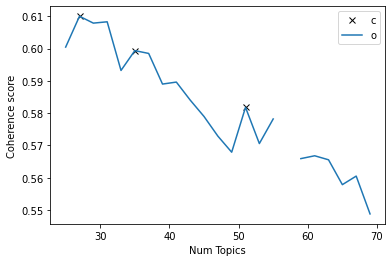

optimal number of topics: [35] with optimal coherence: [0.59936825]

Generated Topics: [(1, '0.157*"integr" + 0.124*"program" + 0.089*"transform" + 0.059*"graph" + 0.049*"construct" + 0.041*"generat" + 0.040*"object" + 0.034*"framework" + 0.030*"class" + 0.027*"basic"'), (18, '0.090*"disord" + 0.056*"syndrom" + 0.047*"injuri" + 0.047*"tissu" + 0.038*"heart" + 0.029*"vascular" + 0.025*"physiolog" + 0.025*"pediatr" + 0.024*"metabol" + 0.024*"pulmonari"'), (24, '0.092*"materi" + 0.081*"properti" + 0.057*"surfac" + 0.051*"composit" + 0.047*"mechan" + 0.031*"metal" + 0.028*"carbon" + 0.027*"polym" + 0.026*"solid" + 0.023*"phase"'), (11, '0.719*"model" + 0.130*"simul" + 0.037*"dynam" + 0.018*"scale" + 0.015*"forecast" + 0.012*"stochast" + 0.011*"numer" + 0.009*"heterogen" + 0.008*"cytolog" + 0.006*"approach"'), (7, '0.080*"surgeri" + 0.080*"techniqu" + 0.065*"principl" + 0.044*"procedur" + 0.044*"basic" + 0.043*"surgic" + 0.028*"repair" + 0.028*"transplant" + 0.027*"indic" + 0.026*"anatomi"'

In [11]:
''' Execution Of The LDA Theme Distribution Solution part 1.
In this part the themes distribution of all the documents and the test documents will be exported'''

all_categories_df = get_subjects(file_name='Categories_engish')
categories_df = pd.DataFrame()
''' Merge to Physical Sciences '''
if (ALL_CATEGORIES):
    categories_df = all_categories_df
else:
    categories_df = all_categories_df[all_categories_df['category'].isin(['COMPUTER SCIENCE', 'TECH SCIENCES AND ENGINEERING', 'MATHEMATICS', 'HEALTH SCIENCES', 'CHEMISTRY', 'PHYSICS', 'ASTRONOMY AND ASTROPHYSICS'])]    
    physical_sciences = categories_df[categories_df['category'].isin(['CHEMISTRY', 'PHYSICS', 'ASTRONOMY AND ASTROPHYSICS'])].content.values.tolist()
    physical_sciences_content = ""
    for idx in range(len(physical_sciences)): 
        physical_sciences_content += physical_sciences[idx][1:-1]
    categories_df = categories_df.drop(categories_df[categories_df['category'].isin(['CHEMISTRY', 'PHYSICS', 'ASTRONOMY AND ASTROPHYSICS'])].index)
    categories_df = categories_df.append({'category':'PHYSICAL SCIENCES', 'content':'[' + physical_sciences_content + ']'}, ignore_index=True)
preprocessed_categories_df = preprocess_subjects(categories_df)
export_subjects_to_json(preprocessed_categories_df)

''' Load the dataset '''
docs_dict = load_split_data()

''' Setting the dictionary and training of the LDA Model.
There are two options based on the variable OPTIMIMUM_NUMBER_OF_TOPICS_ENABLED (default value = True):
1) Find the optimal number of topics
2) Set a fixed number of topics

After the dictionary is set and the lda model is trained they are cached for future use.
'''
print ("Springer Dictionary Path: "+springer_dictionary_path)
if os.path.isfile(springer_dictionary_path):
    print(f'{springer_dictionary_path} found, loading it to memory' )
    dictionary = gensim.corpora.dictionary.Dictionary.load(springer_dictionary_path)
else:
    processed_dict_docs = preprocess(docs=all_categories_df.content.tolist(), language=LANGUAGE, with_stemming=STEMMING_ENABLED)
    dictionary = create_dictionary(processed_dict_docs, not_less_than, not_more_than)
    dictionary.save(springer_dictionary_path)
    print('Springer dictionary created')

print ("Springer LDA Model Path: "+springer_model_path)
if os.path.isfile(springer_model_path):
    print(f'{springer_model_path} found, loading it to memory' )
    lda_model = LdaMallet.load(springer_model_path)
else:
    preprocessed_corpus_dict = load_csv_to_dict(name_by_categories_no("preprocessed_corpus",ALL_CATEGORIES))
    # preprocessed_train_docs = preprocess(docs=preprocessed_corpus_dict.values(), language=LANGUAGE, with_stemming=STEMMING_ENABLED)
    print('Train documents preprocessed')
    if(OPTIMIMUM_NUMBER_OF_TOPICS_ENABLED):
        print(f'Topic modelling starting with the discovery of optimal number of topics based on coherence.')
        lda_model, best_num_of_topics = optimum_topic_modelling(preprocessed_corpus_dict.values(), dictionary, limit, start, step)
        num_of_closest_topics = best_num_of_topics - 1
    else:
        print(f'Topic modelling starting with a fixed number of topics: {num_of_closest_topics}')
        lda_model = default_topic_modelling(train_documents=preprocessed_train_docs, dictionary=dictionary, num_of_topics=fixed_number_of_topics)
    print('LDA Model Trained')
    lda_model.save(springer_model_path)
indicative_docs_dict = load_indicative_docs()
all_indicative_docs_df = pd.DataFrame(columns=['BookID', 'Primary Category', 'Other Categories'])
for sheet_title, indicative_docs_df in indicative_docs_dict.items():
    all_indicative_docs_df = all_indicative_docs_df.append(indicative_docs_df)


print(f'Number of topics {get_number_of_topics(lda_model)}')    
theme_labels = preprocessed_categories_df.category.values.tolist()
topics_with_words = get_words_per_topic(lda_model=lda_model, dictionary=dictionary)
save_to_file(f'{os.getcwd()}/results/{name_by_categories_no("topics_with_words",ALL_CATEGORIES)}', topics_with_words)






In [12]:
''' Preprocess or load cached preprocessed corpus.'''
preprocessed_corpus_dict = {}

if os.path.isfile(f'{os.getcwd()}/{name_by_categories_no("preprocessed_corpus",ALL_CATEGORIES)}.csv'):
    preprocessed_corpus_dict = load_csv_to_dict(name_by_categories_no("preprocessed_corpus",ALL_CATEGORIES))
else: 
    for document_title in docs_dict.keys():
        preprocessed_document_content = preprocess(docs_dict[document_title], LANGUAGE, STEMMING_ENABLED)
        if len(preprocessed_document_content) > 0:
            preprocessed_corpus_dict[document_title] = preprocess(docs_dict[document_title], LANGUAGE, STEMMING_ENABLED)
    save_to_file(name_by_categories_no("preprocessed_corpus", ALL_CATEGORIES), preprocessed_corpus_dict)
    print(f'preprocessed_corpus saved')

In [15]:
''' Calculate p_themes, p_topics'''
p_topics_dict_from_corpus = p_topics_from_corpus_to_lda(lda_model, dictionary, flatten(preprocessed_corpus_dict.values()))
save_to_file(name_by_categories_no("p_topics_from_corpus_to_lda",ALL_CATEGORIES), p_topics_dict_from_corpus)
print("p_topics_from_corpus_to_lda created")

p_themes_given_topic_df = p_themes_given_topics(preprocessed_categories_df=preprocessed_categories_df, topics_with_words=topics_with_words)
p_themes_given_topic_df = normalize_rounded_df(p_themes_given_topic_df)
p_themes_given_topic_df.to_csv(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/{name_by_categories_no("p_themes_given_topics",ALL_CATEGORIES)}.csv'), sep=';')
replace_file_char_with_char(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/{name_by_categories_no("p_themes_given_topics",ALL_CATEGORIES)}.csv'), '.', ',')
print('p_themes_given_topic created')

p_topics_given_themes_df = p_topics_given_themes(lda_model, dictionary, preprocessed_categories_df)
save_to_file(name_by_categories_no("p_topics_given_themes",ALL_CATEGORIES), p_topics_given_themes_df)
print('p_topics_given_themes created')


p_topics_from_corpus_to_lda created
p_themes_given_topic created
p_topics_given_themes created


In [16]:
def words_frequency_in_doc_sorted(document):
    word_frequency = {}
    for word in set(document):
        word_frequency[word] = document.count(word)
    return dict(sorted(word_frequency.items(), key=lambda item: item[1], reverse=True))


def Coverage_of_B_by_S(all_categories):
    all_categories_df = get_subjects(file_name='default_Categories_engish')
    if (all_categories):
        categories_df = all_categories_df
    else:
        categories_df = all_categories_df[all_categories_df['category'].isin(['COMPUTER SCIENCE', 'TECH SCIENCES AND ENGINEERING', 'MATHEMATICS', 'HEALTH SCIENCES', 'CHEMISTRY', 'PHYSICS', 'ASTRONOMY AND ASTROPHYSICS'])]    
        physical_sciences = categories_df[categories_df['category'].isin(['CHEMISTRY', 'PHYSICS', 'ASTRONOMY AND ASTROPHYSICS'])].content.values.tolist()
        physical_sciences_content = ""
        for idx in range(len(physical_sciences)): 
            physical_sciences_content += physical_sciences[idx][1:-1]
        categories_df = categories_df.drop(categories_df[categories_df['category'].isin(['CHEMISTRY', 'PHYSICS', 'ASTRONOMY AND ASTROPHYSICS'])].index)
        categories_df = categories_df.append({'category':'PHYSICAL SCIENCES', 'content':'[' + physical_sciences_content + ']'}, ignore_index=True)
    preprocessed_categories_df = preprocess_subjects(categories_df)
    theme_labels = preprocessed_categories_df.category.values.tolist()
    preprocessed_corpus_dict = load_csv_to_dict(name_by_categories_no("preprocessed_corpus", ALL_CATEGORIES))
    preprocessed_corpus = flatten(preprocessed_corpus_dict.values())
    size_of_preprocessed_corpus = len(preprocessed_corpus)
    S = flatten(preprocessed_categories_df.content.values.tolist())
    coverage_df = pd.DataFrame(index=preprocessed_categories_df.category.values.tolist(), columns=["Coverage_of_B_by_Si"])
    for theme_label in theme_labels:
        theme, theme_content = get_theme(theme_label, preprocessed_categories_df)
        words_frequency_of_theme = words_frequency_in_doc_sorted(theme_content)
        coverage_of_theme = 0
        for word, frequency_in_doc in words_frequency_of_theme.items():
            coverage_of_theme += (frequency_in_doc / frequency_of(word, S)) * (frequency_of(word, preprocessed_corpus) / size_of_preprocessed_corpus)
        coverage_df.loc[theme, 'Coverage_of_B_by_Si'] = coverage_of_theme
    coverage_df.to_csv(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/Coverage_of_B_by_S.csv'), sep=';') 

def Coverage_of_S_by_B(all_categories):
    all_categories_df = get_subjects(file_name='default_Categories_engish')
    if (all_categories):
        categories_df = all_categories_df
    else:
        categories_df = all_categories_df[all_categories_df['category'].isin(['COMPUTER SCIENCE', 'TECH SCIENCES AND ENGINEERING', 'MATHEMATICS', 'HEALTH SCIENCES', 'CHEMISTRY', 'PHYSICS', 'ASTRONOMY AND ASTROPHYSICS'])]    
        physical_sciences = categories_df[categories_df['category'].isin(['CHEMISTRY', 'PHYSICS', 'ASTRONOMY AND ASTROPHYSICS'])].content.values.tolist()
        physical_sciences_content = ""
        for idx in range(len(physical_sciences)): 
            physical_sciences_content += physical_sciences[idx][1:-1]
        categories_df = categories_df.drop(categories_df[categories_df['category'].isin(['CHEMISTRY', 'PHYSICS', 'ASTRONOMY AND ASTROPHYSICS'])].index)
        categories_df = categories_df.append({'category':'PHYSICAL SCIENCES', 'content':'[' + physical_sciences_content + ']'}, ignore_index=True)
    preprocessed_categories_df = preprocess_subjects(categories_df)
    theme_labels = preprocessed_categories_df.category.values.tolist()
    preprocessed_corpus_dict = load_csv_to_dict(name_by_categories_no("preprocessed_corpus", ALL_CATEGORIES))
    preprocessed_corpus = flatten(preprocessed_corpus_dict.values())
    S = flatten(preprocessed_categories_df.content.values.tolist())
    size_of_S = len(S)
    coverage_df = pd.DataFrame(index=preprocessed_categories_df.category.values.tolist(), columns=["Coverage_of_Si_by_B"])
    coverage_df['Coverage_of_Si_by_B'] = 0
    for title, document in preprocessed_corpus_dict.items():
        words_frequency_of_document = words_frequency_in_doc_sorted(document)
        for word, frequency_in_doc in words_frequency_of_document.items():
            for theme_label in theme_labels:
                theme, theme_content = get_theme(theme_label, preprocessed_categories_df)
                coverage_df.loc[theme, 'Coverage_of_Si_by_B']+= (frequency_in_doc / frequency_of(word, preprocessed_corpus)) * (frequency_of(word, theme_content) / len(theme_content))
    coverage_df.to_csv(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/Coverage_of_S_by_B.csv'), sep=';') 

def coverage_of_Document_by_S(all_categories, preprocessed_doc):
    all_categories_df = get_subjects(file_name='default_Categories_engish')
    if (all_categories):
        categories_df = all_categories_df
    else:
        categories_df = all_categories_df[all_categories_df['category'].isin(['COMPUTER SCIENCE', 'TECH SCIENCES AND ENGINEERING', 'MATHEMATICS', 'HEALTH SCIENCES', 'CHEMISTRY', 'PHYSICS', 'ASTRONOMY AND ASTROPHYSICS'])]    
        physical_sciences = categories_df[categories_df['category'].isin(['CHEMISTRY', 'PHYSICS', 'ASTRONOMY AND ASTROPHYSICS'])].content.values.tolist()
        physical_sciences_content = ""
        for idx in range(len(physical_sciences)): 
            physical_sciences_content += physical_sciences[idx][1:-1]
        categories_df = categories_df.drop(categories_df[categories_df['category'].isin(['CHEMISTRY', 'PHYSICS', 'ASTRONOMY AND ASTROPHYSICS'])].index)
        categories_df = categories_df.append({'category':'PHYSICAL SCIENCES', 'content':'[' + physical_sciences_content + ']'}, ignore_index=True)
    preprocessed_categories_df = preprocess_subjects(categories_df)
    theme_labels = preprocessed_categories_df.category.values.tolist()
    size_of_preprocessed_doc = len(preprocessed_doc)
    S = flatten(preprocessed_categories_df.content.values.tolist())
    coverage_df = pd.DataFrame(index=preprocessed_categories_df.category.values.tolist(), columns=["Coverage_of_B_by_Si"])
    for theme_label in theme_labels:
        theme, theme_content = get_theme(theme_label, preprocessed_categories_df)
        words_frequency_of_theme = words_frequency_in_doc_sorted(theme_content)
        coverage_of_theme = 0
        for word, frequency_in_doc in words_frequency_of_theme.items():
            coverage_of_theme += (frequency_in_doc / frequency_of(word, S)) * (frequency_of(word, preprocessed_doc) / size_of_preprocessed_doc)
        coverage_df.loc[theme, 'Coverage_of_Document_by_Si'] = coverage_of_theme
    coverage_df.to_csv(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/{name_by_categories_no("Coverage_of_Document_by_Si", all_categories)}.csv'), sep=';') 

   
def coverage_of_S_by_Document(all_categories, preprocessed_corpus_dict, document_name, preprocessed_doc):
    all_categories_df = get_subjects(file_name='default_Categories_engish')
    if (all_categories):
        categories_df = all_categories_df
    else:
        categories_df = all_categories_df[all_categories_df['category'].isin(['COMPUTER SCIENCE', 'TECH SCIENCES AND ENGINEERING', 'MATHEMATICS', 'HEALTH SCIENCES', 'CHEMISTRY', 'PHYSICS', 'ASTRONOMY AND ASTROPHYSICS'])]    
        physical_sciences = categories_df[categories_df['category'].isin(['CHEMISTRY', 'PHYSICS', 'ASTRONOMY AND ASTROPHYSICS'])].content.values.tolist()
        physical_sciences_content = ""
        for idx in range(len(physical_sciences)): 
            physical_sciences_content += physical_sciences[idx][1:-1]
        categories_df = categories_df.drop(categories_df[categories_df['category'].isin(['CHEMISTRY', 'PHYSICS', 'ASTRONOMY AND ASTROPHYSICS'])].index)
        categories_df = categories_df.append({'category':'PHYSICAL SCIENCES', 'content':'[' + physical_sciences_content + ']'}, ignore_index=True)
    preprocessed_categories_df = preprocess_subjects(categories_df)
    theme_labels = preprocessed_categories_df.category.values.tolist()
    preprocessed_corpus = flatten(preprocessed_corpus_dict.values())
    coverage_df = pd.DataFrame(index=preprocessed_categories_df.category.values.tolist(), columns=["Coverage_of_Si_by_B"])
    coverage_df['Coverage_of_Si_by_Document'] = 0
    words_frequency_of_document = words_frequency_in_doc_sorted(preprocessed_doc)
    for word, frequency_in_doc in words_frequency_of_document.items():
        for theme_label in theme_labels:
            theme, theme_content = get_theme(theme_label, preprocessed_categories_df)
            coverage_df.loc[theme, 'Coverage_of_Si_by_Document']+= (frequency_in_doc / frequency_of(word, preprocessed_doc)) * (frequency_of(word, theme_content) / len(theme_content))
    coverage_df.to_csv(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/{name_by_categories_no("Coverage_of_Si_by_"+document_name, all_categories)}.csv'), sep=';') 



In [17]:

''' Themes distribution for all the documents'''
with open(f'{os.getcwd()}/results/visual/{name_by_categories_no("preprocessed_all_docs", ALL_CATEGORIES)}.json', 'w', encoding='utf8') as fp:
    json.dump(preprocessed_corpus_dict, fp, ensure_ascii=False)
    
export_themes_given_documents(dictionary, lda_model, preprocessed_categories_df, p_themes_given_topic_df , preprocessed_corpus_dict, name_by_categories_no("all_docs_distributions", ALL_CATEGORIES))

print('Springer subject distributions of all documents extracted.')

KeyboardInterrupt: 

In [18]:
''' Themes distribution for the test documents'''
test_docs_dict = {}

for index, indicative_doc_row in all_indicative_docs_df.iterrows():
    document_name = indicative_doc_row["BookID"]
    test_docs_dict[document_name] = preprocessed_corpus_dict[document_name]
with open(f'{os.getcwd()}/results/visual/{name_by_categories_no("preprocessed_test_docs", ALL_CATEGORIES)}.json', 'w', encoding='utf8') as fp:
    json.dump(test_docs_dict, fp, ensure_ascii=False)

export_themes_given_documents(dictionary, lda_model, preprocessed_categories_df, p_themes_given_topic_df, test_docs_dict, name_by_categories_no("test_docs_distributions", ALL_CATEGORIES))


print('Springer subject distributions of test documents extracted.')

In [ ]:
'''Execution of the LDA solution part 2
In this section the exported results will be processed in order to
be exported to files that can be viewed and evaluated visually by the dashboards
in the results/visual folder.'''

''' What follows is helper methods for data export'''

'''Replaces the , with . in order for all the docs (title and content) to be in a standarized format.
This process is for the visualization of the documents and does not affect the exported themes distribution
in csv format.'''
def standarize_document_names(file_name):
    with open(f'{os.getcwd()}/results/visual/{name_by_categories_no(file_name, ALL_CATEGORIES)}.json', encoding='utf8') as json_file:
        docs_dict = json.load(json_file)
        docs_dict = dict((key.replace(',', '.'), value) for (key, value) in docs_dict.items())
    with open(f'{os.getcwd()}/results/visual/{name_by_categories_no(file_name, ALL_CATEGORIES)}.json', 'w', encoding='utf8') as fp:
        json.dump(docs_dict, fp, ensure_ascii=False)

def calculate_dist_distances(row_to_check, candidate_row, column_names, docs_dict):
    to_check_distribution = convert_list_to_float(replace_in_list(row_to_check[column_names].values.tolist(), ",", "."))
    candidate_distribution = convert_list_to_float(replace_in_list(candidate_row[column_names].values.tolist(), ",", "."))
    distribution_distance = distance.jensenshannon(to_check_distribution, candidate_distribution)
    return abs(1000 if distribution_distance == 0 else distribution_distance)

def convert_list_to_float(list_to_covert):
    return  list(map(float, list_to_covert))

def replace_in_list(list_to_replace, replace_from, replace_to):
    return list(map(lambda x: str.replace(x, replace_from, replace_to), list_to_replace))

def sort_dict(dict_to_sort, descending):
    return dict(sorted(dict_to_sort.items(), key=lambda item: item[1], reverse=descending))

def mix_couples_of_documents(groups_of_lists_of_documents_to_mix):
    groups_combinations = list(itertools.combinations(groups_of_lists_of_documents_to_mix, 2))
    mixed_documents = []
    for group_combination in groups_combinations:
        items_to_retrieve = [random.choice(group_combination[0]), random.choice(group_combination[1])]
        mixed_documents.append(items_to_retrieve)
    return mixed_documents
        
''' Export the p_theme_given topic to json for visual representation'''
def export_p_theme_given_topic_to_json(p_theme_given_topic_df):
    p_theme_give_topic_dict = {}
    column_names = p_theme_given_topic_df.columns.values.tolist()
    for topic_id, row in p_theme_given_topic_df.iterrows():
        p_theme_give_topic_dict[topic_id] = dict(zip(column_names, row[column_names]))
    with open(f'{os.getcwd()}/results/visual/{name_by_categories_no("p_themes_given_topics.json",ALL_CATEGORIES)}', 'w', encoding='utf8') as fp:
        json.dump(p_theme_give_topic_dict, fp, ensure_ascii=False)

''' Export the p_theme_given documents to json for visual representation'''        
def export_p_theme_given_documents_to_json(themes_distribution_over_docs_df, filename):
    p_themes_given_doc_dict = {}
    column_names = themes_distribution_over_docs_df.columns.values.tolist()
    for document_name, row in themes_distribution_over_docs_df.iterrows():
        p_themes_given_doc_dict[document_name] = dict(zip(column_names, row[column_names]))
    with open(f'{os.getcwd()}/results/visual/{name_by_categories_no(filename,ALL_CATEGORIES)}.json', 'w', encoding='utf8') as fp:
        json.dump(p_themes_given_doc_dict, fp, ensure_ascii=False)
        
''' export the 3 closest documents to json format for visuala representation'''
def export_closest_documents(themes_distribution_over_docs_df, themes_distribution_over_all_docs_df, num_of_closest_documents, preprocessed_all_docs_json_path, closest_documents_file_name):
    column_names = themes_distribution_over_docs_df.columns.values.tolist()
    closest_documents_df = pd.DataFrame(index=themes_distribution_over_docs_df.index, columns=
                                        [f'theme_{k}_of_document_to_check' for k in range(3)] + 
                                        [f'closest_document_name_{j}' for j in range(num_of_closest_documents)] + 
                                        [f'closest_document_distance_{i}' for i in range(num_of_closest_documents)] + 
                                        [f'theme_{k}_to_closest_document_0' for k in range(3)] + 
                                        [f'closest_document_0_exact_match', f'closest_document_0_match'] + 
                                        [f'theme_{k}_to_closest_document_1' for k in range(3)] + 
                                        [f'closest_document_1_exact_match', f'closest_document_1_match'] + 
                                        [f'theme_{k}_to_closest_document_2' for k in range(3)] + 
                                        [f'closest_document_2_exact_match', f'closest_document_2_match'])
    with open(f'{preprocessed_all_docs_json_path}', encoding='utf8') as json_file:
        docs_dict = json.load(json_file)
    for document_to_check_name, document_to_check_distribution_row in themes_distribution_over_docs_df.iterrows():
        distances_from_document_to_check_df = pd.DataFrame(index=themes_distribution_over_all_docs_df.index, columns=['Distance'])
        distances_from_document_to_check_df['Distance'] = themes_distribution_over_all_docs_df.apply(lambda row: calculate_dist_distances(document_to_check_distribution_row, row, column_names, docs_dict), axis=1)
        distances_from_document_to_check_df = distances_from_document_to_check_df. sort_values(by=[f'Distance'])
        document_distance_index = 0
        for document_name, document_distance in distances_from_document_to_check_df.head(num_of_closest_documents).iterrows():
            closest_documents_df.at[document_to_check_name, f'closest_document_name_{document_distance_index}'] = document_name
            closest_documents_df.at[document_to_check_name, f'closest_document_distance_{document_distance_index}'] = document_distance['Distance']
            document_distance_index += 1
    closest_documents_dict = {}
    closest_documents_names_columns = [f'closest_document_name_{j}' for j in range(num_of_closest_documents)]
    closest_documents_distances_columns = [f'closest_document_distance_{i}' for i in range(num_of_closest_documents)]
    themes_columns_of_document_to_check = [f'theme_{k}_of_document_to_check' for k in range(3)]
    
    for document_name, closest_documents in closest_documents_df.iterrows():
        document_to_check_dist = themes_distribution_over_docs_df.loc[document_name]
        document_to_check_distribution_dict = dict(zip(document_to_check_dist.index.tolist(), document_to_check_dist.values.tolist()))
        sorted_document_to_check_distribution_dict = sort_dict(document_to_check_distribution_dict, True)                                          
        closest_documents[themes_columns_of_document_to_check] = list(sorted_document_to_check_distribution_dict.keys())[:3]
        
        closest_document_names = closest_documents[closest_documents_names_columns].values.tolist()
        i = 0
        for closest_document_name in closest_document_names:
            closest_document_distribution = themes_distribution_over_all_docs_df.loc[closest_document_name]
            closest_document_distribution_dict = dict(zip(closest_document_distribution.index.tolist(), closest_document_distribution.values.tolist()))
            sorted_distribution_dict = sort_dict(closest_document_distribution_dict, True)                                          
            closest_documents[[f'theme_0_to_closest_document_{i}', f'theme_1_to_closest_document_{i}', f'theme_2_to_closest_document_{i}']] = list(sorted_distribution_dict.keys())[:3]
            
            documents_to_check_themes_list = closest_documents[themes_columns_of_document_to_check].values.tolist()
            closest_document_themes_list = closest_documents[[f'theme_0_to_closest_document_{i}', f'theme_1_to_closest_document_{i}', f'theme_2_to_closest_document_{i}']].values.tolist()
            exact_match = documents_to_check_themes_list == closest_document_themes_list
            match = set(documents_to_check_themes_list) == set(closest_document_themes_list)
            closest_documents_df.at[document_name, f'closest_document_{i}_exact_match'] = exact_match            
            closest_documents_df.at[document_name, f'closest_document_{i}_match'] = match
            i += 1
    closest_documents_df.to_csv(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/visual/{name_by_categories_no(closest_documents_file_name, ALL_CATEGORIES)}.csv'), sep=';')
    
    for document_name, closest_documents in closest_documents_df.iterrows():
        closest_document_names = closest_documents[closest_documents_names_columns].values.tolist()
        closest_document_distances = closest_documents[closest_documents_distances_columns].values.tolist()
        closest_documents_dict[document_name] = dict(zip(closest_document_names, closest_document_distances))
    with open(f'{os.getcwd()}/results/visual/{name_by_categories_no(closest_documents_file_name, ALL_CATEGORIES)}.json', 'w', encoding='utf8') as fp:
        json.dump(closest_documents_dict, fp, ensure_ascii=False)
        

''' export the 2 closest documents to json format for visuala representation'''
def export_closest_2_documents(themes_distribution_over_docs_df, themes_distribution_over_all_docs_df, num_of_closest_documents=2):
    column_names = themes_distribution_over_docs_df.columns.values.tolist()
    closest_documents_df = pd.DataFrame(index=themes_distribution_over_docs_df.index, columns=
                                        [f'theme_{k}_of_document_to_check' for k in range(3)] + 
                                        [f'closest_document_name_{j}' for j in range(num_of_closest_documents)] + 
                                        [f'closest_document_distance_{i}' for i in range(num_of_closest_documents)] + 
                                        [f'theme_{k}_to_closest_document_0' for k in range(3)] + 
                                        [f'closest_document_0_exact_match', f'closest_document_0_match'] + 
                                        [f'theme_{k}_to_closest_document_1' for k in range(3)] + 
                                        [f'closest_document_1_exact_match', f'closest_document_1_match'])
    with open(f'{os.getcwd()}/results/visual/{name_by_categories_no("preprocessed_all_docs",ALL_CATEGORIES)}.json', encoding='utf8') as json_file:
        docs_dict = json.load(json_file)
    for document_to_check_name, document_to_check_distribution_row in themes_distribution_over_docs_df.iterrows():
        distances_from_document_to_check_df = pd.DataFrame(index=themes_distribution_over_all_docs_df.index, columns=['Distance'])
        distances_from_document_to_check_df['Distance'] = themes_distribution_over_all_docs_df.apply(lambda row: calculate_dist_distances(document_to_check_distribution_row, row, column_names, docs_dict), axis=1)
        distances_from_document_to_check_df = distances_from_document_to_check_df. sort_values(by=[f'Distance'])
        document_distance_index = 0
        for document_name, document_distance in distances_from_document_to_check_df.head(num_of_closest_documents).iterrows():
            closest_documents_df.at[document_to_check_name, f'closest_document_name_{document_distance_index}'] = document_name
            closest_documents_df.at[document_to_check_name, f'closest_document_distance_{document_distance_index}'] = document_distance['Distance']
            document_distance_index += 1
    closest_documents_names_columns = [f'closest_document_name_{j}' for j in range(num_of_closest_documents)]
    themes_columns_of_document_to_check = [f'theme_{k}_of_document_to_check' for k in range(2)]
    
    for document_name, closest_documents in closest_documents_df.iterrows():
        document_to_check_dist = themes_distribution_over_docs_df.loc[document_name]
        document_to_check_distribution_dict = dict(zip(document_to_check_dist.index.tolist(), document_to_check_dist.values.tolist()))
        sorted_document_to_check_distribution_dict = sort_dict(document_to_check_distribution_dict, True)                                          
        closest_documents[themes_columns_of_document_to_check] = list(sorted_document_to_check_distribution_dict.keys())[:2]
        
        closest_document_names = closest_documents[closest_documents_names_columns].values.tolist()
        i = 0
        for closest_document_name in closest_document_names:
            closest_document_distribution = themes_distribution_over_all_docs_df.loc[closest_document_name]
            closest_document_distribution_dict = dict(zip(closest_document_distribution.index.tolist(), closest_document_distribution.values.tolist()))
            sorted_distribution_dict = sort_dict(closest_document_distribution_dict, True)                                          
            closest_documents[[f'theme_0_to_closest_document_{i}', f'theme_1_to_closest_document_{i}']] = list(sorted_distribution_dict.keys())[:2]
            
            documents_to_check_themes_list = closest_documents[themes_columns_of_document_to_check].values.tolist()
            closest_document_themes_list = closest_documents[[f'theme_0_to_closest_document_{i}', f'theme_1_to_closest_document_{i}']].values.tolist()
            exact_match = documents_to_check_themes_list == closest_document_themes_list
            match = set(documents_to_check_themes_list) == set(closest_document_themes_list)
            closest_documents_df.at[document_name, f'closest_document_{i}_exact_match'] = exact_match            
            closest_documents_df.at[document_name, f'closest_document_{i}_match'] = match
            i += 1
    closest_documents_df.to_csv(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/visual/{name_by_categories_no("closest_2_documents_with_themes",ALL_CATEGORIES)}.csv'), sep=';')

def export_mixed_documents(lda_model, dictionary, topics_with_words, p_themes_given_topics_df):
    theme_labels = p_themes_given_topics_df.columns.values.tolist()
    numeric_p_theme_given_topic_df = p_themes_given_topics_df.replace(',', '.', regex=True)
    numeric_p_theme_given_topic_df = numeric_p_theme_given_topic_df[theme_labels].astype('float')
    all_categories_df = get_subjects(file_name='Categories_engish')
    if (ALL_CATEGORIES):
        categories_df = all_categories_df
    else:
        categories_df = all_categories_df[all_categories_df['category'].isin(['COMPUTER SCIENCE', 'TECH SCIENCES AND ENGINEERING', 'MATHEMATICS', 'HEALTH SCIENCES', 'CHEMISTRY', 'PHYSICS', 'ASTRONOMY AND ASTROPHYSICS'])]    
        physical_sciences = categories_df[categories_df['category'].isin(['CHEMISTRY', 'PHYSICS', 'ASTRONOMY AND ASTROPHYSICS'])].content.values.tolist()
        physical_sciences_content = ""
        for idx in range(len(physical_sciences)): 
            physical_sciences_content += physical_sciences[idx][1:-1]
        categories_df = categories_df.drop(categories_df[categories_df['category'].isin(['CHEMISTRY', 'PHYSICS', 'ASTRONOMY AND ASTROPHYSICS'])].index)
        categories_df = categories_df.append({'category':'PHYSICAL SCIENCES', 'content':'[' + physical_sciences_content + ']'}, ignore_index=True)
    preprocessed_categories_df = preprocess_subjects(categories_df)
 
    with open(f'{os.getcwd()}/results/visual/{name_by_categories_no("preprocessed_test_docs",ALL_CATEGORIES)}.json', encoding='utf8') as json_file:
        docs_dict = json.load(json_file)
    documents_to_evaluate = {}
    if(ALL_CATEGORIES == False):
        MATHEMATICS_DOCS = replace_in_list(['Differential and Difference Equations with Applications', 'Functional Analysis and Evolution Equations'], ',', '.')
        HEALTH_SCIENCE_DOCS = replace_in_list(['Oncology', 'Atlas of Genetic Diagnosis and Counseling', 'Oncology'], ',', '.')
        
        documents_to_evaluate["MATHEMATICS"] = MATHEMATICS_DOCS
        documents_to_evaluate["HEALTH_SCIENCE"] = HEALTH_SCIENCE_DOCS
  
    else:
        MATHEMATICS_DOCS = replace_in_list(['Fourier Series, Fourier Transform and Their Applications to Mathematical Physics', 'Convergence and Summability of Fourier Transforms and Hardy Spaces', 'Advances in Nonlinear Analysis via the Concept of Measure of Noncompactness'], ',', '.')
        COMPUTER_SCIENCE_DOCS = replace_in_list(['Distributed Computing ', 'Knowledge-Based and Intelligent Information and Engineering Systems', 'Life System Modeling and Intelligent Computing'], ',', '.')
        HEALTH_SCIENCE_DOCS = replace_in_list(['Pathology of the Gastrointestinal Tract', 'Pulmonary Hypertension in Adult Congenital Heart Disease', 'Pulmonary Vasculature Redox Signaling in Health and Disease'], ',', '.')
        ENGINEERING_DOCS = replace_in_list(['Handbook of Manufacturing Engineering and Technology', 'Quality of Service in Heterogeneous Networks', 'Experimental and Applied Mechanics Volume 6'], ',', '.')
        FINANCE_DOCS = replace_in_list(['Corporate Governance in Developing Economies', 'Principles of Public Finance', 'Inflation Dynamics in South Africa'], ',', '.')
        documents_to_evaluate["MATHEMATICS"] = MATHEMATICS_DOCS
        documents_to_evaluate["COMPUTER_SCIENCE"] = COMPUTER_SCIENCE_DOCS
        documents_to_evaluate["HEALTH_SCIENCE"] = HEALTH_SCIENCE_DOCS
        documents_to_evaluate["ENGINEERING"] = ENGINEERING_DOCS
        documents_to_evaluate["FINANCE"] = FINANCE_DOCS
    mixed_documents = mix_couples_of_documents(documents_to_evaluate.values())
    mixed_documents_names = ["_".join([str(mixed_document[0]), str(mixed_document[1])]) for mixed_document in mixed_documents]
    mixed_documents_df = pd.DataFrame(index=mixed_documents_names, columns=theme_labels)
    mixed_documents_df.index.astype(str, copy=False)
    for mixed_document_couple in mixed_documents:
        preprocessed_mixed_doc = docs_dict[mixed_document_couple[0]] + docs_dict[mixed_document_couple[1]]
        mixed_document_idx = "_".join([str(mixed_document_couple[0]), str(mixed_document_couple[1])])
        themes_given_document_dict = p_themes_given_document(preprocessed_doc=preprocessed_mixed_doc, lda_model=lda_model, dictionary=dictionary, preprocessed_categories_df=preprocessed_categories_df, p_themes_given_topics_df=numeric_p_theme_given_topic_df)
        for theme_label, themes_distribution_for_mixed_document in themes_given_document_dict.items(): 
            mixed_documents_df.at[mixed_document_idx, theme_label] = themes_distribution_for_mixed_document 
    mixed_documents_df = normalize_rounded_df(mixed_documents_df)
    mixed_documents_df.to_csv(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/{name_by_categories_no("mixed_docs",ALL_CATEGORIES)}.csv'), sep=';')
    replace_file_char_with_char(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/{name_by_categories_no("mixed_docs",ALL_CATEGORIES)}.csv'), '.', ',')
    
    mixed_docs_dict = { "_".join([str(mix_doc[0]), str(mix_doc[1])]):docs_dict[mix_doc[0]] + docs_dict[mix_doc[1]] for mix_doc in mixed_documents}
    with open(f'{os.getcwd()}/results/visual/{name_by_categories_no("preprocessed_mixed_docs",ALL_CATEGORIES)}.json', 'w', encoding='utf8') as fp:
        json.dump(mixed_docs_dict, fp, ensure_ascii=False)
    
    p_themes_given_mixed_doc_dict = {}
    column_names = mixed_documents_df.columns.values.tolist()
    
    for document_name, row in mixed_documents_df.iterrows():
        p_themes_given_mixed_doc_dict[document_name] = dict(zip(column_names, row[column_names]))
    with open(f'{os.getcwd()}/results/visual/{name_by_categories_no("p_themes_given_mixed_documents",ALL_CATEGORIES)}.json', 'w', encoding='utf8') as fp:
        json.dump(p_themes_given_mixed_doc_dict, fp, ensure_ascii=False)

        
def export_mixed_document_with_closest_documents(lda_model, dictionary, topics_with_words, p_theme_given_topic_df, themes_distribution_over_docs_df, themes_distribution_over_all_docs_df):
    theme_labels = p_theme_given_topic_df.columns.values.tolist()
    numeric_p_theme_given_topic_df = p_theme_given_topic_df.replace(',', '.', regex=True)
    numeric_p_theme_given_topic_df = numeric_p_theme_given_topic_df[theme_labels].astype('float')
    num_of_closest_documents = 3
    closest_documents_df = pd.DataFrame(index=themes_distribution_over_docs_df.index, columns=
                                        [f'closest_document_name_{j}' for j in range(num_of_closest_documents)] + 
                                        [f'closest_document_distance_{i}' for i in range(num_of_closest_documents)])
    with open(f'{os.getcwd()}/results/visual/{name_by_categories_no("preprocessed_all_docs",ALL_CATEGORIES)}.json', encoding='utf8') as json_file:
        docs_dict = json.load(json_file)
    math_document_name = 'Fourier Series, Fourier Transform and Their Applications to Mathematical Physics'.replace(',', '.')
    health_science_document_name = 'Pathology of the Gastrointestinal Tract'
    
    for document_to_check_name in [math_document_name, health_science_document_name]:
        distances_from_document_to_check_df = pd.DataFrame(index=themes_distribution_over_all_docs_df.index, columns=['Distance'])
        distances_from_document_to_check_df['Distance'] = themes_distribution_over_all_docs_df.apply(lambda row: calculate_dist_distances(themes_distribution_over_docs_df.loc[document_to_check_name], row, theme_labels, docs_dict), axis=1)
        distances_from_document_to_check_df = distances_from_document_to_check_df. sort_values(by=[f'Distance'])
        document_distance_index = 0
        for document_name, document_distance in distances_from_document_to_check_df.head(num_of_closest_documents).iterrows():
            closest_documents_df.at[document_to_check_name, f'closest_document_name_{document_distance_index}'] = document_name.replace(',', '.')
            closest_documents_df.at[document_to_check_name, f'closest_document_distance_{document_distance_index}'] = document_distance['Distance']
            document_distance_index += 1
        
    math_closest_documents = closest_documents_df.loc[math_document_name, [f'closest_document_name_{j}' for j in range(num_of_closest_documents)]].values.tolist()
    health_science_closest_documents = closest_documents_df.loc[health_science_document_name, [f'closest_document_name_{j}' for j in range(num_of_closest_documents)]].values.tolist()
    mixed_documents_names = [math_document_name + '_' + health_science_document_name]
    for i in range(num_of_closest_documents):
        closest_math_name = math_closest_documents[i]
        closest_health_science_name = health_science_closest_documents[i]
        mixed_document_name = closest_math_name + '_' + closest_health_science_name
        mixed_documents_names.append(mixed_document_name)
    
    mixed_documents_df = pd.DataFrame(index=[f'{i}_{mixed_documents_names[i]}' for i in range(len(mixed_documents_names))], columns=theme_labels)
         
    ''' Closest documents to mixed document'''
    for i in range(len(mixed_documents_names)): 
        mixed_document_name = mixed_documents_names[i]
        preprocessed_mixed_doc = docs_dict[mixed_document_name.split('_')[0]] + docs_dict[mixed_document_name.split('_')[1]]
        themes_given_document_dict = p_themes_given_document(preprocessed_doc=preprocessed_mixed_doc, lda_model=lda_model, dictionary=dictionary, preprocessed_categories_df=preprocessed_categories_df, p_themes_given_topics_df=numeric_p_theme_given_topic_df)
        for theme_label, themes_distribution_for_mixed_document in themes_given_document_dict.items(): 
            mixed_documents_df.at[f'{i}_{mixed_document_name}', theme_label] = themes_distribution_for_mixed_document
    
    mixed_documents_df = normalize_rounded_df(mixed_documents_df)
    mixed_documents_df.to_csv(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/{name_by_categories_no("mixed_closest_docs",ALL_CATEGORIES)}.csv'), sep=';')
    replace_file_char_with_char(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/{name_by_categories_no("mixed_closest_docs",ALL_CATEGORIES)}.csv'), '.', ',')
           
    mixed_docs_dict = { f'{mixed_documents_names.index(mix_doc_name)}_{mix_doc_name}':docs_dict[mix_doc_name.split('_')[0]] + docs_dict[mix_doc_name.split('_')[1]] for mix_doc_name in mixed_documents_names}
    with open(f'{os.getcwd()}/results/visual/{name_by_categories_no("preprocessed_mixed_closest_docs",ALL_CATEGORIES)}.json', 'w', encoding='utf8') as fp:
        json.dump(mixed_docs_dict, fp, ensure_ascii=False)
    
    p_themes_given_mixed_doc_dict = {}
    column_names = mixed_documents_df.columns.values.tolist()
    
    for document_name, row in mixed_documents_df.iterrows():
        p_themes_given_mixed_doc_dict[document_name] = dict(zip(column_names, row[column_names]))
    with open(f'{os.getcwd()}/results/visual/{name_by_categories_no("p_themes_given_mixed_closest_documents",ALL_CATEGORIES)}.json', 'w', encoding='utf8') as fp:
        json.dump(p_themes_given_mixed_doc_dict, fp, ensure_ascii=False)

def sample(documents_dict, documents_percentages, number_of_words):
    document_label_samples = []
    for i in range(number_of_words):
        document_label_idx = np.random.choice(np.arange(0, len(documents_dict.values())), p=documents_percentages)
        document_label = list(documents_dict)[document_label_idx]
        document_label_samples.append(document_label)
    
    with open(f'{os.getcwd()}/results/visual/{name_by_categories_no("artificial_doc_terms_frequency",ALL_CATEGORIES)}.json', 'w', encoding='utf8') as fp:
        json.dump(words_frequency_in_doc_sorted(document_label_samples), fp, ensure_ascii=False)
        
    sampled_document = []
    for document_label in document_label_samples:
        random_word = random.choice(documents_dict[document_label])
        sampled_document.append(random_word)
    return sampled_document

def sample_artificial_document():
    dictionary = gensim.corpora.dictionary.Dictionary.load(springer_dictionary_path)
    lda_model = LdaMallet.load(springer_model_path)
    topics_with_words = topics_with_words = get_words_per_topic(lda_model=lda_model, dictionary=dictionary)
    preprocessed_categories_df = get_preprocessed_subjects(subjects_file_name='default_Categories_engish')
    p_themes_given_topic_df = p_themes_given_topics(preprocessed_categories_df=preprocessed_categories_df, topics_with_words=topics_with_words)
    math_label, MATH = get_theme("MATHEMATICS", preprocessed_categories_df)
    economic_label, ECONOMIC = get_theme("ECONOMIC SCIENCES", preprocessed_categories_df) if ALL_CATEGORIES else get_theme("PHYSICAL SCIENCES", preprocessed_categories_df)
    health_label, HEALTH = get_theme("HEALTH SCIENCES", preprocessed_categories_df)
    
    artificial_doc = sample(dict(zip([math_label,economic_label, health_label],[MATH,ECONOMIC,HEALTH])), [0.5,0.3,0.2], 3000)
    print(artificial_doc)
    artificial_doc_distribution = p_themes_given_document(preprocessed_doc=artificial_doc, lda_model=lda_model, dictionary=dictionary, preprocessed_categories_df=preprocessed_categories_df, p_themes_given_topics_df=p_themes_given_topic_df)
    themes_for_documents_df = pd.DataFrame(index=['artificial_doc'], columns=artificial_doc_distribution.keys())
    for theme_label, themes_distribution_for_document in artificial_doc_distribution.items():
        themes_for_documents_df.at['artificial_doc', theme_label] = themes_distribution_for_document
    
    themes_for_documents_df = normalize_rounded_df(themes_for_documents_df)
    themes_for_documents_df.to_csv(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/{name_by_categories_no("artificial_doc_distribution",ALL_CATEGORIES)}.csv'), sep=';')
    replace_file_char_with_char(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/{name_by_categories_no("artificial_doc_distribution",ALL_CATEGORIES)}.csv'), '.', ',')
    column_names = themes_for_documents_df.columns.values.tolist()
    artificial_doc_themes_distribution_dict = {}
    for doc_name, row in themes_for_documents_df.iterrows():
        artificial_doc_themes_distribution_dict[doc_name] = dict(zip(column_names, row[column_names]))
    
    with open(f'{os.getcwd()}/results/visual/{name_by_categories_no("artificial_doc_distribution",ALL_CATEGORIES)}.json', 'w', encoding='utf8') as fp:
        json.dump(artificial_doc_themes_distribution_dict, fp, ensure_ascii=False)
    
    preprocessed_artificial_doc_dict = {}
    preprocessed_artificial_doc_dict['artificial_doc'] = artificial_doc
    with open(f'{os.getcwd()}/results/visual/{name_by_categories_no("preprocessed_artificial_doc",ALL_CATEGORIES)}.json', 'w', encoding='utf8') as fp:
        json.dump(preprocessed_artificial_doc_dict, fp, ensure_ascii=False)
    S = flatten(preprocessed_categories_df.content.values.tolist())
    coverage_of_document_by_S = words_count_of_document(artificial_doc, S) / len(artificial_doc)
    print(f'\n Coverage of Artificial Document: {coverage_of_document_by_S}')
    # coverage_df = themes_for_documents_df.apply(lambda row: coverage_of_document_by_S * row, axis=1)
    # print(coverage_df)
    # coverage_df.to_csv(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/{name_by_categories_no("artificial_doc_coverage",ALL_CATEGORIES)}.csv'), sep=';')
    # replace_file_char_with_char(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/{name_by_categories_no("artificial_doc_coverage",ALL_CATEGORIES)}.csv'), '.', ',')

def export_standard_category_distribution(subject_name):
    dictionary = gensim.corpora.dictionary.Dictionary.load(springer_dictionary_path)
    lda_model = LdaMallet.load(springer_model_path)
    topics_with_words = topics_with_words = get_words_per_topic(lda_model=lda_model, dictionary=dictionary)
    preprocessed_categories_df = get_preprocessed_subjects(subjects_file_name='default_Categories_engish')
    theme_labels = preprocessed_categories_df.category.values.tolist()
    p_themes_given_topic_df = p_themes_given_topics(preprocessed_categories_df=preprocessed_categories_df, topics_with_words=topics_with_words)
    subject_label, subject_content = get_theme(subject_name, preprocessed_categories_df)

    s_i_distribution = p_themes_given_document(preprocessed_doc=subject_content, lda_model=lda_model, dictionary=dictionary, preprocessed_categories_df=preprocessed_categories_df, p_themes_given_topics_df=p_themes_given_topic_df)
    print(s_i_distribution)
    themes_for_documents_df = pd.DataFrame(index=[subject_name], columns=theme_labels)
    for theme_label, themes_distribution_for_document in s_i_distribution.items():
        themes_for_documents_df.at[subject_name, theme_label] = themes_distribution_for_document
    themes_for_documents_df = normalize_rounded_df(themes_for_documents_df)
    themes_for_documents_df.to_csv(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/{name_by_categories_no(subject_name+"_distribution",ALL_CATEGORIES)}.csv'), sep=';')
    column_names = themes_for_documents_df.columns.values.tolist()
    si_distribution_dict = {}
    
    for doc_name, row in themes_for_documents_df.iterrows():
        si_distribution_dict[doc_name] = dict(zip(column_names, row[column_names]))

    with open(f'{os.getcwd()}/results/visual/{name_by_categories_no(subject_name+"_distribution",ALL_CATEGORIES)}.json', 'w', encoding='utf8') as fp:
        json.dump(si_distribution_dict, fp, ensure_ascii=False)

    preprocessed_si_doc_dict = {}
    preprocessed_si_doc_dict[subject_name] = subject_content
    with open(f'{os.getcwd()}/results/visual/{name_by_categories_no("preprocessed_"+subject_name+"_doc",ALL_CATEGORIES)}.json', 'w', encoding='utf8') as fp:
        json.dump(preprocessed_si_doc_dict, fp, ensure_ascii=False)
    print(f'\n {subject_name} distribution exported and length of {subject_name} is: {len(subject_content)}')

In [ ]:
'''Execution of the LDA solution part 2
In this section the exported results will be processed in order to
be exported to files that can be viewed and evaluated visually by the dashboards
in the results/visual folder.'''
    
''' This is the execution process'''

p_theme_given_topic_df = pd.read_csv(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/{name_by_categories_no("p_themes_given_topics",ALL_CATEGORIES)}.csv'), sep=";", index_col=0)
export_p_theme_given_topic_to_json(p_theme_given_topic_df)
    
standarize_document_names("preprocessed_all_docs")
standarize_document_names("preprocessed_test_docs")


print('themes given topics exported.')
themes_distribution_over_docs_df = pd.read_csv(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/{name_by_categories_no("test_docs_distributions",ALL_CATEGORIES)}.csv'), sep=";", index_col=0)
themes_distribution_over_docs_df.index = themes_distribution_over_docs_df.index.str.replace(',', '.')
export_p_theme_given_documents_to_json(themes_distribution_over_docs_df, "test_docs_distributions")
print('themes given test documents exported.')    
themes_distribution_over_all_docs_df = pd.read_csv(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/{name_by_categories_no("all_docs_distributions",ALL_CATEGORIES)}.csv'), sep=";", index_col=0)
themes_distribution_over_all_docs_df.index = themes_distribution_over_all_docs_df.index.str.replace(',', '.')

print('loaded all docs distributions from all datasets')

export_p_theme_given_documents_to_json(themes_distribution_over_all_docs_df, f'{name_by_categories_no("all_docs_distributions",ALL_CATEGORIES)}')
print('themes given all documents exported.')

In [ ]:
export_closest_documents(themes_distribution_over_docs_df, themes_distribution_over_all_docs_df, 3, f'{os.getcwd()}/results/visual/{name_by_categories_no("preprocessed_all_docs",ALL_CATEGORIES)}.json' , "closest_documents_distances_from_springer")
print('closest 3 documents exported.')
export_closest_2_documents(themes_distribution_over_docs_df, themes_distribution_over_all_docs_df)
print('closest 2 documents exported.')


In [ ]:
topics_with_words = pd.read_csv(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/{name_by_categories_no("topics_with_words",ALL_CATEGORIES)}.csv'), sep=";", index_col=0)
dictionary = gensim.corpora.dictionary.Dictionary.load(springer_dictionary_path)
lda_model = LdaMallet.load(springer_model_path)
p_theme_given_topic_df = pd.read_csv(os.path.join(os.path.abspath(''), f'{os.getcwd()}/results/{name_by_categories_no("p_themes_given_topics",ALL_CATEGORIES)}.csv'), sep=";", index_col=0)
    
export_mixed_documents(lda_model, dictionary, topics_with_words, p_theme_given_topic_df)
export_mixed_document_with_closest_documents(lda_model, dictionary, topics_with_words, p_theme_given_topic_df, themes_distribution_over_docs_df, themes_distribution_over_all_docs_df)
print('mixed documents exported.')
print ('Multisubject LDA on Springer is completed.')